# Case Studies Part 1

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# import functions from modsim

from modsim import *

This chapter presents case studies where you can apply the tools we have learned so far to problems involving population growth.

## Historical World Population

The Wikipedia page about world population growth includes estimates for world population from 12,000 years ago to the present (see <https://en.wikipedia.org/wiki/World_population_estimates.html>).

The following cells download an archived version of this page and read the data into a Pandas `DataFrame`.

In [2]:
from pandas import read_html

filename = 'World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
len(tables)

6

In [3]:
table1 = tables[1]
table1.tail()

,Population Reference Bureau (1973–2016)[15],United Nations Department of Economic and Social Affairs (2015)[16],Maddison (2008)[17],HYDE (2010)[citation needed],Tanton (1994)[18],Biraben (1980)[19],McEvedy & Jones (1978)[20],Thomlinson (1975)[21],Durand (1974)[22],Clark (1967)[23]
Year,,,,,,,,,,
1913,NaN,NaN,1793.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920,NaN,1860.0,1863.,1912.,NaN,NaN,NaN,NaN,NaN,1968.
1925,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,NaN,NaN
1930,NaN,2070.0,NaN,2092.,NaN,NaN,NaN,NaN,NaN,2145.
1940,NaN,2300.0,2299.,2307.,NaN,NaN,NaN,NaN,NaN,2340.


Some of the values are null because not all researchers provide estimates for the same dates.

Again, we'll replace the long column names with more convenient abbreviations.

In [4]:
table1.columns = ['PRB', 'UN', 'Maddison', 'HYDE', 'Tanton', 
                  'Biraben', 'McEvedy & Jones', 'Thomlinson', 'Durand', 'Clark']

Some of the estimates are in a form Pandas doesn't recognize as numbers, but we can coerce them to be numeric.

In [5]:
for col in table1.columns:
    table1[col] = pd.to_numeric(table1[col], errors='coerce')

Here are the results.  Notice that we are working in millions now, not billions.

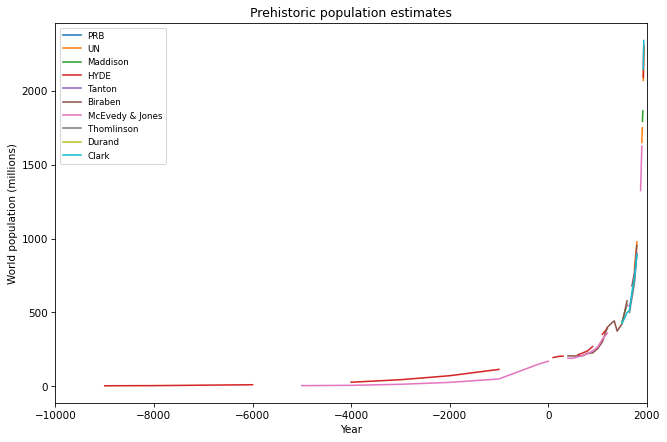

In [6]:
table1.plot()
decorate(xlim=[-10000, 2000], xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistoric population estimates')
plt.legend(fontsize='small');

We can use `xlim` to zoom in on everything after Year 0.

The following figure shows the estimates of several research groups from 1 CE to the near present.

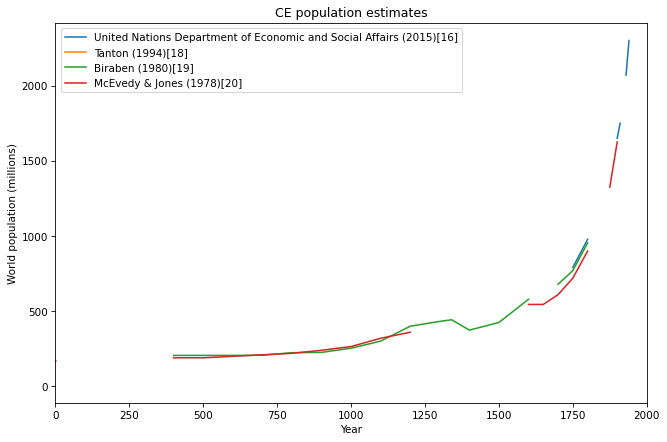

In [5]:
table1.plot()
decorate(xlim=[0, 2000], xlabel='Year', 
         ylabel='World population (millions)',
         title='CE population estimates')

We seek to find a model that fits these estimates.  Obviously, it seems like
some sort of exponential model would be appropriate, but we'll have to
do some work to find the best parameters.

One of the challenges is that the estimates are not equally spaced in time. One way to handle this is to lump ALL of the data together in a single data set, and then fit the model to the combined dataset.


[3.53076166e-06 6.81044374e-03 2.26033870e-01] [[ 3.02266098e-12 -4.46362006e-10 -1.06019178e-08]
 [-4.46362006e-10  6.59711623e-08  1.51774265e-06]
 [-1.06019178e-08  1.51774265e-06  1.60375888e-04]]
[0.00047205 0.00430682] [[ 3.87820154e-08 -4.36425715e-08]
 [-4.36425715e-08  4.91949997e-08]]


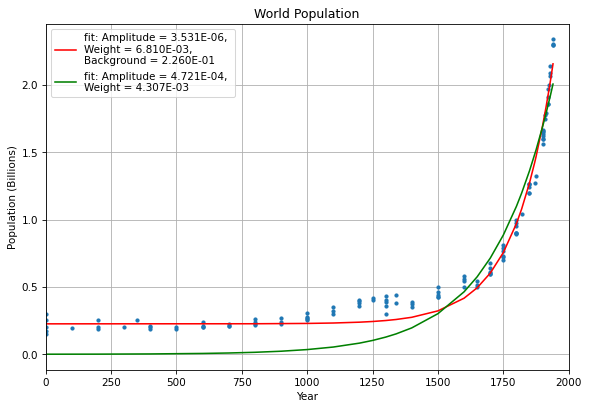

In [6]:
# Step 1: stacking the series vertically
df = pd.DataFrame(pd.concat([table1[i] for i in table1.columns], axis = 0))
df.columns = {'Population'}

# Step 2: make sure everything is numeric
df2 = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

# Step 3: Add a time index, the population in billions, and then sort
#           by time
time = df2.index
population = list(df2['Population']/1000.0)
time_indices = time.argsort()
time_sorted = time[time_indices[::1]]
population_sorted = [population[i] for i in time_indices]

# Step 4: Plot the data
plt.plot(time_sorted,population_sorted,'.')

# Step 5: Fit the data to an exponential with a constant offset
from scipy.optimize import curve_fit

# Define the function to fit: exponential with a constant offset
def fitfunction(x,a,b,c):
    return a*np.exp(b*np.array(x))+c

# Define another fit function: exponential with no offset
def fitfunction2(x,a,b):
    return a*np.exp(b*np.array(x))

init_vals = [0.1,0.0000001,0.0]
popt, pcov = curve_fit(fitfunction, time_sorted, population_sorted, p0=init_vals)

init_vals2 = [0.1,0.0000001]
popt2, pcov2 = curve_fit(fitfunction2, time_sorted, population_sorted, p0=init_vals2)

print(popt,pcov)
print(popt2,pcov2)

plt.plot(time_sorted, fitfunction(time_sorted, *popt), 'r-', label = 'fit: Amplitude = %.3E, \nWeight = %.3E, \nBackground = %.3E' % tuple(popt))

plt.plot(time_sorted, fitfunction2(time_sorted, *popt2), 'g-', label = 'fit: Amplitude = %.3E, \nWeight = %.3E' % tuple(popt2))

leg = plt.legend()
plt.title("World Population")
plt.xlabel('Year')
plt.ylabel('Population (Billions)')
plt.xlim(0,2000)
plt.legend()
plt.grid(True)


# Intermediate Conclusion

The fit is not great, but it is not bad either.  Clearly, the fit is much better for a constant offset than for no offset.  The fit is also better for the constant offset than for the linear offset.  So, we will use the constant offset model going forward.

Next, we will look at the fit in the 1700s and 1800s, and then we will look at the fit in the 1900s.

(1750.0, 1950.0)

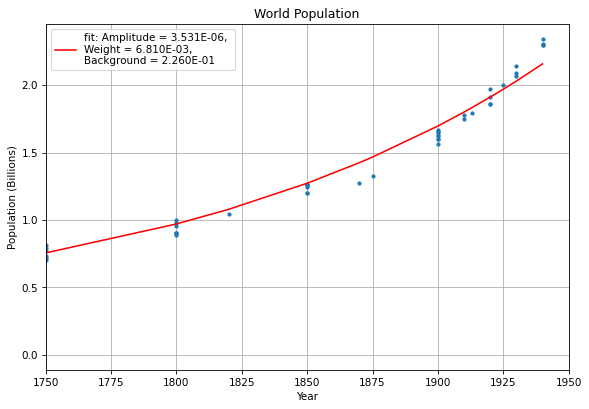

In [7]:
plt.plot(time_sorted,population_sorted,'.')

plt.plot(time_sorted, fitfunction(time_sorted, *popt), 'r-', label = 'fit: Amplitude = %.3E, \nWeight = %.3E, \nBackground = %.3E' % tuple(popt))

#plt.plot(time_sorted, fitfunction2(time_sorted, *popt2), 'g.', label = 'fit: Amplitude = %.3E, \nWeight = %.3E' % tuple(popt2))

leg = plt.legend()
plt.title("World Population")
plt.xlabel('Year')
plt.ylabel('Population (Billions)')
plt.grid(True)

plt.xlim(1750,1950)


We see here that the fit does not work particularly well from about 1850 onward.  We will look at this in more detail in the next section.